# Homework 2, *part 1* (40 points)

This warm-up problem set is provided to help you get used to PyTorch.

Please, only fill parts marked with "`Your code here`".

In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

import torch
assert torch.__version__ >= '1.0.0'

To learn best practices $-$ for example,

* how to choose between `.sqrt()` and `.sqrt_()`,
* when to use `.view()` and how is it different from `.reshape()`,
* which `dtype` to use,

$-$ you are expected to google a lot, read tutorials on the Web and study documentation.

Quick documentation on functions and modules is available with `?` and `help()`, like so:

In [ ]:
help(torch.sqrt)

In [ ]:
# to close the Jupyter help bar, press `Esc` or `q`
?torch.cat

## Task 1 (3 points)

Use tensors only: **no lists, loops, numpy arrays etc.**

$\rho(\theta)$ is defined in polar coordinate system:

$$\rho(\theta) = (1 + 0.9 \cdot \cos{8\theta} ) \cdot (1 + 0.1 \cdot \cos{24\theta}) \cdot (0.9 + 0.05 \cdot \cos {200\theta}) \cdot (1 + \sin{\theta})$$

1. Create a regular grid of 1000 values of $\theta$ between $-\pi$ and $\pi$.
2. Compute $\rho(\theta)$ at these values.
3. Convert it into Cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)).

In [2]:
theta =torch.linspace(-np.pi,np.pi,1000)
# (1) Your code here
assert theta.shape == (1000,)

rho =(1+0.9*torch.cos(8*theta))*(1+0.1*torch.cos(24*theta))*(0.9+0.05*torch.cos(200*theta))*(1+torch.sin(theta)) 

# (2) Your code here
assert torch.is_same_size(rho, theta)
x = rho*torch.cos(theta)
y = rho*torch.sin(theta)

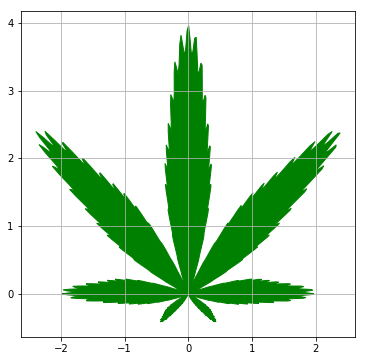

In [3]:
# Run this cell and make sure the plot is correct
plt.figure(figsize=[6,6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

## Task 2 (7 points)

Use tensors only: **no lists, loops, numpy arrays etc.**

We will implement [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway's_Game_of_Life) in PyTorch.

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)

If you skipped the URL above, here are the rules:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* At one step in time, the generation update happens:
  * Any living cell that has 2 or 3 neighbors survives, otherwise (0,1 or 4+ neighbors) it dies
  * Any cell with exactly 3 neighbors becomes alive if it was dead

You are given a reference numpy implementation of the update step. Your task is to convert it to PyTorch.

In [4]:
from scipy.signal import correlate2d as conv2d

def numpy_update(alive_map):
    # Count neighbours with convolution
    conv_kernel = np.array([[1,1,1],
                            [1,0,1],
                            [1,1,1]])
    
    num_alive_neighbors = conv2d(alive_map, conv_kernel, mode='same')
    
    # Apply game rules
    born = np.logical_and(num_alive_neighbors == 3, alive_map == 0)
    survived = np.logical_and(np.isin(num_alive_neighbors, [2,3]), alive_map == 1)
    
    np.copyto(alive_map, np.logical_or(born, survived))

In [5]:
def torch_update(alive_map):
    """
    Game of Life update function that does to `alive_map` exactly the same as `numpy_update`.
    
    :param alive_map: `torch.tensor` of shape `(height, width)` and dtype `torch.float32`
        containing 0s (dead) an 1s (alive)
    """
    conv_kernel = torch.tensor([[1.,1.,1.],
                                [1.,0.,1.],
                                [1.,1.,1.]])
    # Your code here
    a=(alive_map.view(1,1,alive_map.shape[0], alive_map.shape[1]))
    b=(conv_kernel.view(1,1,conv_kernel.shape[0], conv_kernel.shape[1]))
    
    num_alive_neighbors = torch.conv2d(a,b, padding=1)
    
    born=(num_alive_neighbors==3)&(alive_map==0)
    survived=((num_alive_neighbors==2)|(num_alive_neighbors==3))&(alive_map==1)
    alive_map[:]=born|survived
    
    return alive_map

In [6]:
# Generate a random initial map
alive_map_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
alive_map_torch = torch.tensor(alive_map_numpy).float().clone()

numpy_update(alive_map_numpy)
torch_update(alive_map_torch)

# results should be identical
assert np.allclose(alive_map_torch.numpy(), alive_map_numpy), \
    "Your PyTorch implementation doesn't match numpy_update."
print("Well done!")

Well done!


<IPython.core.display.Javascript object>


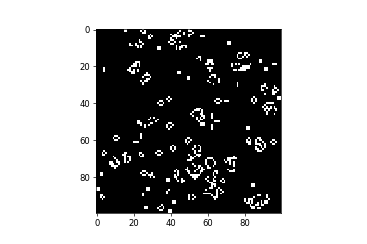

In [9]:
%matplotlib notebook
plt.ion()

# initialize game field
alive_map = np.random.choice([0, 1], size=(100, 100))
alive_map = torch.tensor(alive_map).float()

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    torch_update(alive_map)
    
    # re-draw image
    ax.clear()
    ax.imshow(alive_map.numpy(), cmap='gray')
    fig.canvas.draw()

<IPython.core.display.Javascript object>


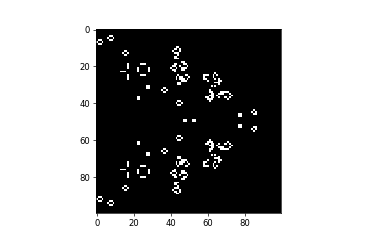

In [10]:
# A fun setup for your amusement
alive_map = np.arange(100) % 2 + np.zeros([100, 100])
alive_map[48:52, 50] = 1

alive_map = torch.tensor(alive_map).float()

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(150):
    torch_update(alive_map)
    ax.clear()
    ax.imshow(alive_map.numpy(), cmap='gray')
    fig.canvas.draw()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

## Task 3 (30 points)

You have to solve yet another character recognition problem: 10 letters, ~14 000 train samples.

For this, we ask you to build a multilayer perceptron (*i.e. a neural network of linear layers*) from scratch using **low-level** PyTorch interface.

Requirements:
1. at least 82% accuracy
2. at least 2 linear layers
3. use [softmax followed by categorical cross-entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/)

**You are NOT allowed to use**
* numpy arrays
* `torch.nn`, `torch.optim`
* convolutions

Tips:

* Pick random batches (either shuffle data before each epoch or sample each batch randomly).
* Do not initialize weights with zeros ([learn why](https://stats.stackexchange.com/questions/27112/danger-of-setting-all-initial-weights-to-zero-in-backpropagation)). Gaussian noise with small variance will do.
* 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
* To improve accuracy, consider changing layers' sizes, nonlinearities, optimization methods, weights initialization.
* Don't use GPU yet.

**Reproducibility requirement**: you have to format your code cells so that `Cell -> Run All` on a fresh notebook **reliably** trains your model to the desired accuracy in a couple of minutes and reports the accuracy reached.

Happy googling!

In [22]:
np.random.seed(666)
torch.manual_seed(666)

from notmnist import load_notmnist
letters = 'ABCDEFGHIJ' 
X_train, y_train, X_test, y_test = map(torch.tensor, load_notmnist(letters=letters))
X_train.squeeze_()
X_test.squeeze_();

Parsing...
found broken img: .\notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: .\notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]


<IPython.core.display.Javascript object>


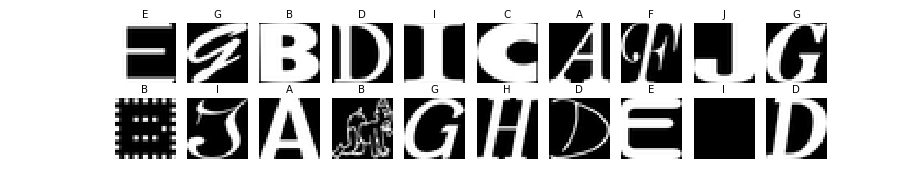

In [23]:
import matplotlib.pyplot as plt
fig, axarr = plt.subplots(2, 10, figsize=(15,3))

for idx, ax in enumerate(axarr.ravel()):
    ax.imshow(X_train[idx].numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(letters[y_train[idx]])

The cell below has an example layout for encapsulating your neural network. Feel free to modify the interface if you need to (add arguments, add return values, add methods etc.). For example, you may want to add a method `do_gradient_step()` that executes one optimization algorithm (SGD / Adadelta / Adam / ...) step.

In [13]:
#Lets reshape our Data
def updateOutput(input):
        output = input.reshape(len(input), -1)
        return output
X_train=updateOutput(X_train)
X_test=updateOutput(X_test)

In [14]:
#lets make Onehotencoding
from sklearn.preprocessing import OneHotEncoder

preprots=OneHotEncoder(categories=[range(10)],sparse=False)
y_encoded=preprots.fit_transform(y_train.reshape(-1,1))
y_encoded=torch.tensor(y_encoded)
y_t=preprots.fit_transform(y_test.reshape(-1,1))
y_encoded_t=torch.tensor(y_t)

In [15]:
def get_batches(dataset, batch_size):
        X, Y = dataset
        n_samples = X.shape[0]

        # Shuffle at the start of epoch
        indices = torch.randperm(n_samples)
        #torch.randint(indices)

        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)

            batch_idx = indices[start:end]

            yield X[batch_idx], Y[batch_idx]

In [16]:
class NeuralNet:
    def __init__(self):
        
        self.W_1 = (torch.randn(784, 426)/100).requires_grad_(True)
        self.b_1 = (torch.randn(426)/100).requires_grad_(True)
        self.W_2 = (torch.randn(426, 100)/100).requires_grad_(True)
        self.b_2 = (torch.randn(100)/100).requires_grad_(True)
        self.W_3 = (torch.randn(100, 10)/100).requires_grad_(True)
        self.b_3 = (torch.randn(10)/100).requires_grad_(True)
        
        self.learning_rate = 0.1
    
        
    def forward(self,input):
#         print(self.W_1)
        self.output=input@self.W_1+self.b_1
        self.output=self.output.sigmoid()
        self.output=self.output@self.W_2+self.b_2
        self.output=self.output.sigmoid()
        self.output=self.output@self.W_3+self.b_3
        self.output=self.output.softmax(dim=0)
        return self.output
    def loss_func(self,input,target):
        input=input.double()
#         print(input.type())
#         print(target.type())
        loss = -torch.mean(torch.sum(target*(torch.log(input)), dim = 1))
               
        return loss
   
    
    def backprop(self):
        with torch.no_grad(): # as we do not need to include this operation to gradients
            
            self.W_1 -= self.learning_rate * self.W_1.grad
            self.b_1 -= self.learning_rate * self.b_1.grad
            self.W_2 -= self.learning_rate * self.W_2.grad
            self.b_2 -= self.learning_rate * self.b_2.grad
            self.W_3 -= self.learning_rate * self.W_3.grad
            self.b_3 -= self.learning_rate * self.b_3.grad
            
        self.W_1.grad = torch.zeros_like(self.W_1)
        self.b_1.grad = torch.zeros_like(self.b_1)
        self.W_2.grad = torch.zeros_like(self.W_2)
        self.b_2.grad = torch.zeros_like(self.b_2)
        self.W_3.grad = torch.zeros_like(self.W_3)
        self.b_3.grad = torch.zeros_like(self.b_3)
        
    
    def fit(self,X,Y):
        batch_size=256
        for i in range(50):
            for x_batch, y_batch in get_batches((X, Y), batch_size): 
                #print(x_batch)
                x = self.forward(x_batch)
                #print(x)
                loss = self.loss_func(x, y_batch)
                #print(y_batch)
                loss.backward()
                self.backprop()
    def predict(self,images):
        predicted=self.forward(images)
        return predicted

In [17]:
model=NeuralNet()
training=model.fit(X_train,y_encoded)
pred_tr=model.predict(X_train)
pred_te=model.predict(X_test)

In [18]:
def accuracy(y_pred, y_true):
    result=(torch.argmax(y_pred,dim=1)==y_true).numpy().sum()/len(y_true)
    return result

    
    # Your code here

In [19]:
test_acc=accuracy(pred_te,y_test.long())*100
train_acc=accuracy(pred_tr,y_train.long())*100
print("Train accuracy: %.2f, test accuracy: %.2f" % (train_acc, test_acc))

assert test_acc >= 82.0, "You have to do better"

Train accuracy: 88.44, test accuracy: 87.31


Lets cheak on SKlearn

In [20]:
from sklearn.metrics import accuracy_score

score=accuracy_score(torch.argmax(y_encoded_t,dim=1),torch.argmax(pred_te,dim=1))
score

0.8731040375988037